### Interface for accessing the VQA dataset.

Code in this section comes from https://github.com/GT-Vision-Lab/VQA; the official implementation to handle the dataset. We've updated them for the newest version of pytorch.

In [8]:
# 
# This code is based on the code written by Tsung-Yi Lin for MSCOCO Python API available at the following link: 
# (https://github.com/pdollar/coco/blob/master/PythonAPI/pycocotools/coco.py).

# The following functions are defined:
#  VQA        - VQA class that loads VQA annotation file and prepares data structures.
#  getQuesIds - Get question ids that satisfy given filter conditions.
#  getImgIds  - Get image ids that satisfy given filter conditions.
#  loadQA     - Load questions and answers with the specified question ids.
#  showQA     - Display the specified questions and answers.
#  loadRes    - Load result file and create result object.

# Help on each function can be accessed by: "help(COCO.function)"

import json
import datetime
import copy

class VQA:
	def __init__(self, annotation_file=None, question_file=None):
		"""
       	Constructor of VQA helper class for reading and visualizing questions and answers.
        :param annotation_file (str): location of VQA annotation file
        :return:
		"""
        # load dataset
		self.dataset = {}
		self.questions = {}
		self.qa = {}
		self.qqa = {}
		self.imgToQA = {}
		if not annotation_file == None and not question_file == None:
			print('loading VQA annotations and questions into memory...')
			time_t = datetime.datetime.utcnow()
			dataset = json.load(open(annotation_file, 'r'))
			questions = json.load(open(question_file, 'r'))
			print(datetime.datetime.utcnow() - time_t)
			self.dataset = dataset
			self.questions = questions
			self.createIndex()

	def createIndex(self):
		# create index
		print('creating index...')
		imgToQA = {ann['image_id'] : [] for ann in self.dataset['annotations']}
		qa =  {ann['question_id']: [] for ann in self.dataset['annotations']}
		qqa = {ann['question_id']: [] for ann in self.dataset['annotations']}
		for ann in self.dataset['annotations']:
			imgToQA[ann['image_id']] += [ann]
			qa[ann['question_id']] = ann
		for ques in self.questions['questions']:
			qqa[ques['question_id']] = ques
		print('index created!')

		# create class members
		self.qa = qa
		self.qqa = qqa
		self.imgToQA = imgToQA

	def info(self):
		"""
		Print information about the VQA annotation file.
		:return:
		"""
		for key, value in self.datset['info'].items():
			print('%s: %s'%(key, value))

	def getQuesIds(self, imgIds=[], quesTypes=[], ansTypes=[]):
		"""
		Get question ids that satisfy given filter conditions. default skips that filter
		:param 	imgIds    (int array)   : get question ids for given imgs
				quesTypes (str array)   : get question ids for given question types
				ansTypes  (str array)   : get question ids for given answer types
		:return:    ids   (int array)   : integer array of question ids
		"""
		imgIds 	  = imgIds    if type(imgIds)    == list else [imgIds]
		quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
		ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

		if len(imgIds) == len(quesTypes) == len(ansTypes) == 0:
			anns = self.dataset['annotations']
		else:
			if not len(imgIds) == 0:
				anns = sum([self.imgToQA[imgId] for imgId in imgIds if imgId in self.imgToQA],[])
			else:
				anns = self.dataset['annotations']
			anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
			anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
		ids = [ann['question_id'] for ann in anns]
		return ids

	def getImgIds(self, quesIds=[], quesTypes=[], ansTypes=[]):
		"""
		Get image ids that satisfy given filter conditions. default skips that filter
		:param quesIds   (int array)   : get image ids for given question ids
				quesTypes (str array)   : get image ids for given question types
				ansTypes  (str array)   : get image ids for given answer types
		:return: ids     (int array)   : integer array of image ids
		"""
		quesIds   = quesIds   if type(quesIds)   == list else [quesIds]
		quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
		ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

		if len(quesIds) == len(quesTypes) == len(ansTypes) == 0:
			anns = self.dataset['annotations']
		else:
			if not len(quesIds) == 0:
				anns = sum([self.qa[quesId] for quesId in quesIds if quesId in self.qa],[])
			else:
				anns = self.dataset['annotations']
			anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
			anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
		ids = [ann['image_id'] for ann in anns]
		return ids

	def loadQA(self, ids=[]):
		"""
		Load questions and answers with the specified question ids.
		:param ids (int array)       : integer ids specifying question ids
		:return: qa (object array)   : loaded qa objects
		"""
		if type(ids) == list:
			return [self.qa[id] for id in ids]
		elif type(ids) == int:
			return [self.qa[ids]]

	def showQA(self, anns):
		"""
		Display the specified annotations.
		:param anns (array of object): annotations to display
		:return: None
		"""
		if len(anns) == 0:
			return 0
		for ann in anns:
			quesId = ann['question_id']
			print("Question: %s" %(self.qqa[quesId]['question']))
			for ans in ann['answers']:
				print("Answer %d: %s" %(ans['answer_id'], ans['answer']))
		
	def loadRes(self, resFile, quesFile):
		"""
		Load result file and return a result object.
		:param   resFile (str)     : file name of result file
		:return: res (obj)         : result api object
		"""
		res = VQA()
		res.questions = json.load(open(quesFile))
		res.dataset['info'] = copy.deepcopy(self.questions['info'])
		res.dataset['task_type'] = copy.deepcopy(self.questions['task_type'])
		res.dataset['data_type'] = copy.deepcopy(self.questions['data_type'])
		res.dataset['data_subtype'] = copy.deepcopy(self.questions['data_subtype'])
		res.dataset['license'] = copy.deepcopy(self.questions['license'])

		print('Loading and preparing results...     ')
		time_t = datetime.datetime.utcnow()
		anns    = json.load(open(resFile))
		assert type(anns) == list, 'results is not an array of objects'
		annsQuesIds = [ann['question_id'] for ann in anns]
		assert set(annsQuesIds) == set(self.getQuesIds()), \
		'Results do not correspond to current VQA set. Either the results do not have predictions for all question ids in annotation file or there is atleast one question id that does not belong to the question ids in the annotation file.'
		for ann in anns:
			quesId 			     = ann['question_id']
			if res.dataset['task_type'] == 'Multiple Choice':
				assert ann['answer'] in self.qqa[quesId]['multiple_choices'], 'predicted answer is not one of the multiple choices'
			qaAnn                = self.qa[quesId]
			ann['image_id']      = qaAnn['image_id'] 
			ann['question_type'] = qaAnn['question_type']
			ann['answer_type']   = qaAnn['answer_type']
		print('DONE (t=%0.2fs)'%((datetime.datetime.utcnow() - time_t).total_seconds()))
		res.dataset['annotations'] = anns
		res.createIndex()
		return res

loading VQA annotations and questions into memory...
0:00:06.106547
creating index...
index created!
Question: How many sinks?
Answer 1: 2
Answer 2: 2
Answer 3: 2
Answer 4: 2
Answer 5: 2
Answer 6: 2
Answer 7: 2
Answer 8: 2
Answer 9: 2
Answer 10: 2


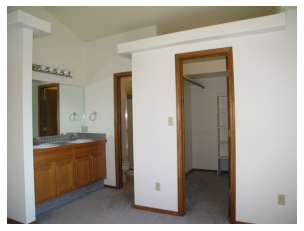

Question: Are these roses?
Answer 1: yes
Answer 2: yes
Answer 3: yes
Answer 4: yes
Answer 5: yes
Answer 6: no
Answer 7: no
Answer 8: yes
Answer 9: yes
Answer 10: yes


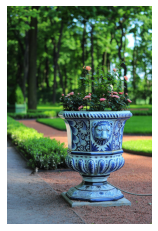

Question: Are they getting ready for bed?
Answer 1: no
Answer 2: yes
Answer 3: no
Answer 4: no
Answer 5: no
Answer 6: no
Answer 7: no
Answer 8: no
Answer 9: no
Answer 10: no


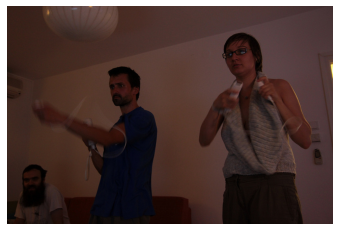

In [16]:
import random
import skimage.io as io
import matplotlib.pyplot as plt
import os

dataDir		='datasets'
versionType ='v2_' # this should be '' when using VQA v2.0 dataset
taskType    ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='train2014'
annFile     ='%s/%s%s_%s_annotations.json'%(dataDir, versionType, dataType, dataSubType)
quesFile    ='%s/%s%s_%s_%s_questions.json'%(dataDir, versionType, taskType, dataType, dataSubType)
imgDir 		= '%s/%s/' %(dataDir, dataSubType)

# initialize VQA api for QA annotations
vqa=VQA(annFile, quesFile)

# load and display QA annotations for given question types
"""
All possible quesTypes for abstract and mscoco has been provided in respective text files in ../QuestionTypes/ folder.
"""
annIds = vqa.getQuesIds(quesTypes='how many');   
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

# load and display QA annotations for given answer types
"""
ansTypes can be one of the following
yes/no
number
other
"""
annIds = vqa.getQuesIds(ansTypes='yes/no');   
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""
ids = vqa.getImgIds()
annIds = vqa.getQuesIds(imgIds=random.sample(ids,5));  
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])  
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()
else:
	print(imgDir + imgFilename)